# Usefule resources:
## OpenCV NLM Example:
https://docs.opencv.org/3.4/d5/d69/tutorial_py_non_local_means.html

## IPOL
http://www.ipol.im/pub/art/2011/bcm_nlm/

## 2005 IEEE NLM article
https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=1467423

## NLM OpenCV GitHub:
- https://github.com/opencv/opencv/tree/4.x/modules/photo/src
- https://github.com/opencv/opencv/blob/4.x/modules/photo/src/fast_nlmeans_denoising_invoker.hpp (most important)
- https://github.com/opencv/opencv/blob/4.x/modules/photo/src/fast_nlmeans_denoising_invoker_commons.hpp (utils)

## Image sequencies 
https://static.aminer.org/pdf/PDF/000/317/196/spatio_temporal_wiener_filtering_of_image_sequences_using_a_parametric.pdf  
Page 5: *Unfortunately, this method fails when the standard deviation of the noise exceeds
the contrast of edges.*  
Mostly section 7.1

In [6]:
%load_ext autoreload
%autoreload 2
import numpy as np
from skimage.io import imread, imshow
import cv2 as cv
from nlm import denoise_nlm, show_original_with_denoised, denoise_nlm_with_history, compare_img_quality, denoise_nlm_with_history_smart, create_padded_img
from matplotlib import pyplot as plt
import torch


prefix = "/home/martinb/SCHOOL/pv162_project/"
samples_dark_path = prefix + "data/input_images/samples_dark/"

def crop(img, offset=0):
    return img[5+offset:55+offset, 80+offset:130+offset]

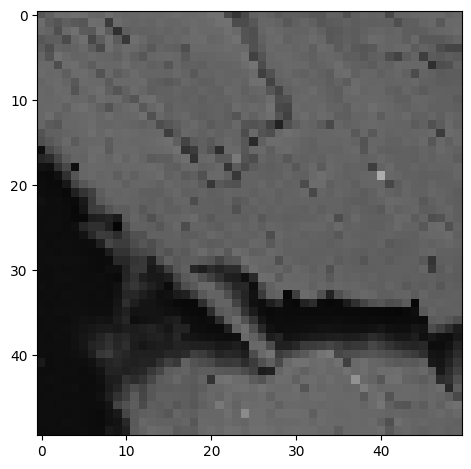

In [7]:
img_gt = imread(prefix + "data/input_images/sample_dark_200x100.png", as_gray=True).astype(np.uint8)
img_gt_float = img_gt.astype(np.float64) / 255
imshow(crop(img_gt))
# img.shape

In [8]:
# PARAMETERS
sd = 0.1254076 # estimated using R
strength = 0.35 * sd # 0.078 
compare_window_size = 7 # ODD
search_window_size = 35 # ODD! bigger than compare win

In [6]:
i = 0
img = imread(samples_dark_path + f"{i}.png", as_gray=True).astype(np.uint8)
img_float = img.astype(np.float64) / 255
denoised_img = denoise_nlm(crop(img_float), search_window_size, compare_window_size, strength, sd)

1/50 rows done, elapsed time: 0.30286192893981934s
2/50 rows done, elapsed time: 0.4194955825805664s
3/50 rows done, elapsed time: 0.5448882579803467s
4/50 rows done, elapsed time: 0.6779561042785645s
5/50 rows done, elapsed time: 0.8219504356384277s
6/50 rows done, elapsed time: 0.9722259044647217s
7/50 rows done, elapsed time: 1.1329498291015625s
8/50 rows done, elapsed time: 1.3008966445922852s
9/50 rows done, elapsed time: 1.4812610149383545s
10/50 rows done, elapsed time: 1.6741828918457031s
11/50 rows done, elapsed time: 1.874588966369629s
12/50 rows done, elapsed time: 2.0804336071014404s
13/50 rows done, elapsed time: 2.2934398651123047s
14/50 rows done, elapsed time: 2.5171337127685547s
15/50 rows done, elapsed time: 2.7407212257385254s
16/50 rows done, elapsed time: 2.96683406829834s
17/50 rows done, elapsed time: 3.1979472637176514s
18/50 rows done, elapsed time: 3.4252736568450928s
19/50 rows done, elapsed time: 3.651273488998413s
20/50 rows done, elapsed time: 3.8753230571

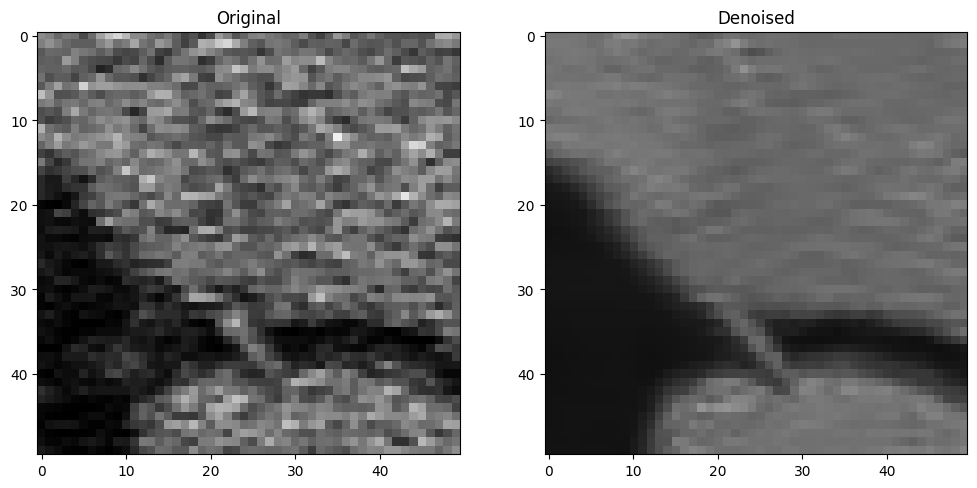

In [7]:
show_original_with_denoised(crop(img_float), denoised_img)

In [8]:
i = 0
img = imread(samples_dark_path + f"{i}.png", as_gray=True).astype(np.uint8)
img_float = img.astype(np.float64) / 255
denoised_img = denoise_nlm(crop(img_float), search_window_size, compare_window_size, strength, sd)

1/50 rows done, elapsed time: 0.27797460556030273s
2/50 rows done, elapsed time: 0.39744019508361816s
3/50 rows done, elapsed time: 0.525632381439209s
4/50 rows done, elapsed time: 0.6661148071289062s
5/50 rows done, elapsed time: 0.8159842491149902s
6/50 rows done, elapsed time: 0.9705142974853516s
7/50 rows done, elapsed time: 1.1302237510681152s
8/50 rows done, elapsed time: 1.296769380569458s
9/50 rows done, elapsed time: 1.478522777557373s
10/50 rows done, elapsed time: 1.667222499847412s
11/50 rows done, elapsed time: 1.882094144821167s
12/50 rows done, elapsed time: 2.095329523086548s
13/50 rows done, elapsed time: 2.313748836517334s
14/50 rows done, elapsed time: 2.546590566635132s
15/50 rows done, elapsed time: 2.7863311767578125s
16/50 rows done, elapsed time: 3.0209546089172363s
17/50 rows done, elapsed time: 3.2612428665161133s
18/50 rows done, elapsed time: 3.4882254600524902s
19/50 rows done, elapsed time: 3.7148797512054443s
20/50 rows done, elapsed time: 3.9445512294769

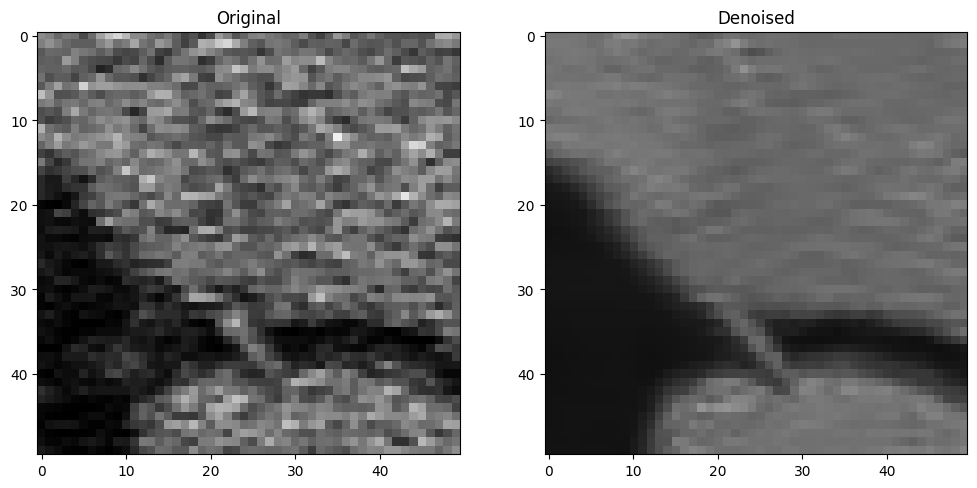

In [9]:
show_original_with_denoised(crop(img_float), denoised_img)

In [10]:
# quality of the denoised img
compare_img_quality(crop(img_float), crop(img_gt_float), denoised_img)

# PSNR
  66.46068772206652
  71.36727261151377
# SSIM
  0.28493636298612834
  0.3814666584130843
# MSE
  0.01468965474817378
  0.004746277207689


In [48]:
# load history
count = 5
history = []
for c in range(1, 1 + count):
    history.append(crop((imread(samples_dark_path + f"{c}.png", as_gray=True).astype(np.float64)) / 255))

In [49]:
i = 0
img_0 = crop((imread(samples_dark_path + f"{i}.png", as_gray=True).astype(np.float64)) / 255)
denoised_img_0 = denoise_nlm_with_history(img_0, history, search_window_size, compare_window_size, strength, sd)

1/50 rows done, elapsed time: 2.3434994220733643s
2/50 rows done, elapsed time: 4.592301845550537s
3/50 rows done, elapsed time: 6.85083794593811s
4/50 rows done, elapsed time: 9.208840370178223s
5/50 rows done, elapsed time: 11.775331497192383s
6/50 rows done, elapsed time: 14.412842273712158s
7/50 rows done, elapsed time: 17.209570169448853s
8/50 rows done, elapsed time: 20.123899936676025s
9/50 rows done, elapsed time: 22.98825168609619s
10/50 rows done, elapsed time: 25.623740196228027s
11/50 rows done, elapsed time: 27.49864935874939s
12/50 rows done, elapsed time: 29.37044072151184s
13/50 rows done, elapsed time: 31.421876668930054s
14/50 rows done, elapsed time: 33.50110340118408s
15/50 rows done, elapsed time: 35.61169195175171s
16/50 rows done, elapsed time: 37.75395441055298s
17/50 rows done, elapsed time: 40.00492024421692s
18/50 rows done, elapsed time: 42.27486562728882s
19/50 rows done, elapsed time: 44.61971616744995s
20/50 rows done, elapsed time: 46.90774202346802s
21/

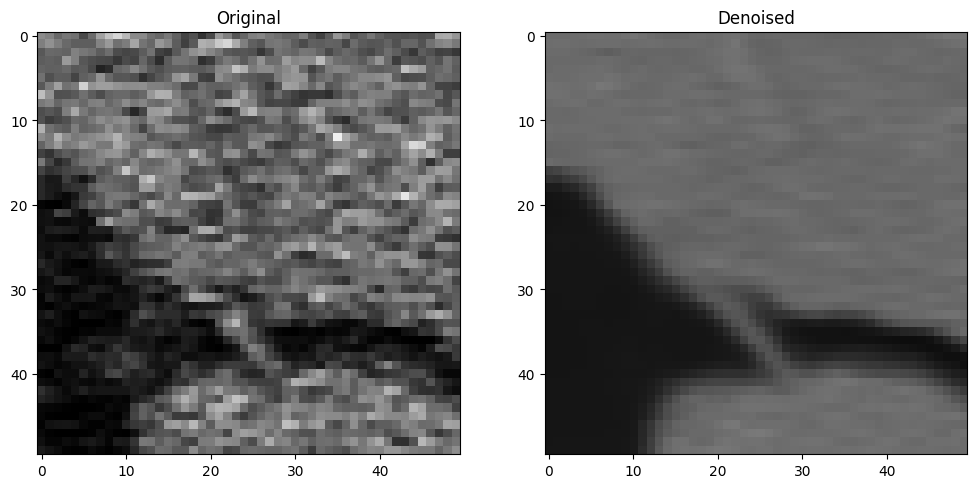

In [50]:
show_original_with_denoised(img_0, denoised_img_0)

In [51]:
compare_img_quality(img_0, crop(img_gt_float), denoised_img_0)

# PSNR
  66.46068772206652
  72.74926878338151
# SSIM
  0.28493636298612834
  0.40764471879818776
# MSE
  0.01468965474817378
  0.003452657369622392


# Using history for missing data

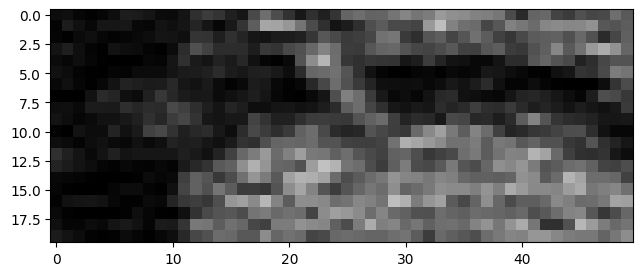

In [33]:
# mask = np.ones(img_0.shape)
# mask[30:, :] = 0
i = 0
img_0 = crop((imread(samples_dark_path + f"{i}.png", as_gray=True).astype(np.float64)) / 255)
img_0 = img_0[30:, :]
#imshow(img_0[30:, :])


In [39]:
# PARAMETERS
sd = 0.1254076 # estimated using R
strength = 0.35 * sd # 0.078 
compare_window_size = 7 # ODD
search_window_size = 35 # ODD! bigger than compare win

In [42]:
# load history
i = 0
img_0 = crop((imread(samples_dark_path + f"{i}.png", as_gray=True).astype(np.float64)) / 255)
img_0 = img_0[:, :30]

count = 5
history = []
for c in range(1, 1 + count):
    history.append(crop((imread(samples_dark_path + f"{c}.png", as_gray=True).astype(np.float64)) / 255))
    
denoised_img_0_incomplete = denoise_nlm_with_history_smart(img_0, history, search_window_size, compare_window_size, strength, sd)

1/50 rows done, elapsed time: 0.6878845691680908s
2/50 rows done, elapsed time: 1.2473461627960205s
3/50 rows done, elapsed time: 1.8364176750183105s
4/50 rows done, elapsed time: 2.4756994247436523s
5/50 rows done, elapsed time: 3.1419248580932617s
6/50 rows done, elapsed time: 3.829766035079956s
7/50 rows done, elapsed time: 4.546295881271362s
8/50 rows done, elapsed time: 5.306798219680786s
9/50 rows done, elapsed time: 6.081362009048462s
10/50 rows done, elapsed time: 6.885983228683472s
11/50 rows done, elapsed time: 7.724862813949585s
12/50 rows done, elapsed time: 8.611645698547363s
13/50 rows done, elapsed time: 9.528807640075684s
14/50 rows done, elapsed time: 10.494518995285034s
15/50 rows done, elapsed time: 11.470204591751099s
16/50 rows done, elapsed time: 12.485866069793701s
17/50 rows done, elapsed time: 13.535322189331055s
18/50 rows done, elapsed time: 14.611304521560669s
19/50 rows done, elapsed time: 15.700050354003906s
20/50 rows done, elapsed time: 16.77004170417785

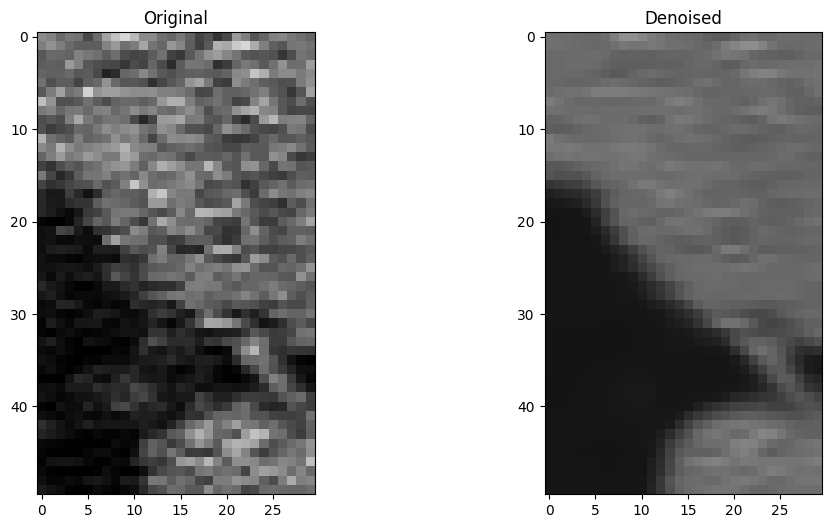

In [43]:
show_original_with_denoised(img_0, denoised_img_0_incomplete)

In [106]:
compare_img_quality(img_0, crop(img_gt_float), denoised_img_0_incomplete)

# PSNR
  66.46068772206652
  72.07674464768704
# SSIM
  0.28493636298612834
  0.4003229075069186
# MSE
  0.01468965474817378
  0.004030935937574306


# Chaning the window size


In [45]:
# PARAMETERS
sd = 0.1254076 # estimated using R
strength = 0.35 * sd # 0.078 
compare_window_size = 7 # ODD
search_window_size = 35 # ODD! bigger than compare win

In [46]:
# load history
count = 5
history = []
for c in range(1, 1 + count):
    history.append(crop((imread(samples_dark_path + f"{c}.png", as_gray=True).astype(np.float64)) / 255))

In [47]:
denoised_img_smaller_sw = denoise_nlm_with_history(img_0, history, search_window_size, compare_window_size, strength, sd)

1/50 rows done, elapsed time: 1.184528112411499s
2/50 rows done, elapsed time: 2.355943441390991s
3/50 rows done, elapsed time: 3.563877820968628s
4/50 rows done, elapsed time: 4.89504861831665s
5/50 rows done, elapsed time: 6.305713653564453s
6/50 rows done, elapsed time: 7.8084142208099365s
7/50 rows done, elapsed time: 9.342952251434326s
8/50 rows done, elapsed time: 11.032938718795776s
9/50 rows done, elapsed time: 12.716363906860352s
10/50 rows done, elapsed time: 14.410410404205322s
11/50 rows done, elapsed time: 16.307543516159058s
12/50 rows done, elapsed time: 18.05788278579712s
13/50 rows done, elapsed time: 19.95146155357361s
14/50 rows done, elapsed time: 22.191505670547485s
15/50 rows done, elapsed time: 24.360158920288086s
16/50 rows done, elapsed time: 26.359902143478394s
17/50 rows done, elapsed time: 28.455599308013916s
18/50 rows done, elapsed time: 30.529720783233643s
19/50 rows done, elapsed time: 32.78249454498291s
20/50 rows done, elapsed time: 34.97613048553467s


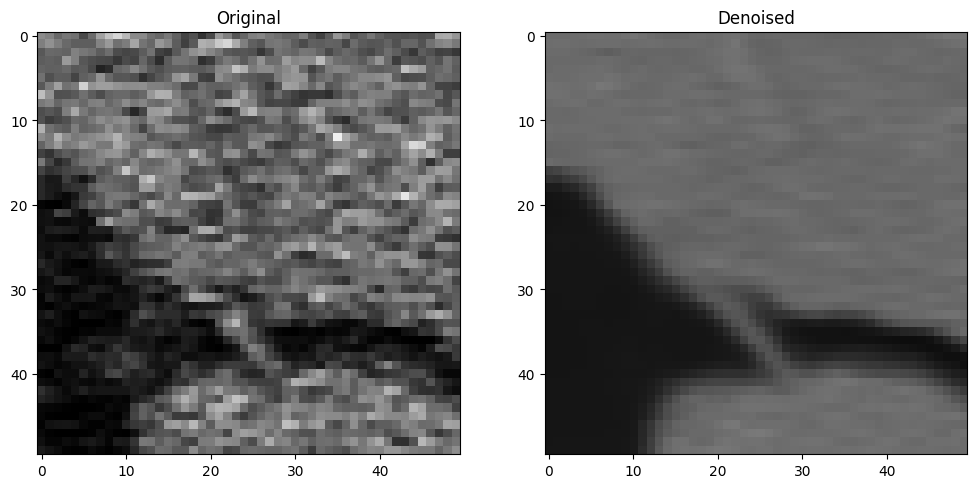

In [38]:
show_original_with_denoised(img_0, denoised_img_smaller_sw)

In [87]:
compare_img_quality(crop(img_float), crop(img_gt_float), denoised_img_smaller_sw)

# PSNR
  66.46068772206652
  65.53907533763254
# SSIM
  0.28493636298612834
  0.11657054262900185
# MSE
  0.01468965474817378
  0.018162382893988978


In [52]:
compare_img_quality(img_0, crop(img_gt_float), denoised_img_0)

# PSNR
  66.46068772206652
  72.74926878338151
# SSIM
  0.28493636298612834
  0.40764471879818776
# MSE
  0.01468965474817378
  0.003452657369622392


In [18]:
i = 0
cropped_img = crop((imread(samples_dark_path + f"{i}.png", as_gray=True).astype(np.float64)) / 255, 30)

# load history
count = 5
history = []
for c in range(1, 1 + count):
    history.append(crop((imread(samples_dark_path + f"{c}.png", as_gray=True).astype(np.float64)) / 255, 30))
    
denoised_cropped_img = denoise_nlm_with_history(cropped_img, history, search_window_size, compare_window_size, strength, sd)

1/50 rows done, elapsed time: 0.8013525009155273s
2/50 rows done, elapsed time: 1.4279108047485352s
3/50 rows done, elapsed time: 2.1058437824249268s
4/50 rows done, elapsed time: 2.823822021484375s
5/50 rows done, elapsed time: 3.5985896587371826s
6/50 rows done, elapsed time: 4.430833101272583s
7/50 rows done, elapsed time: 5.305182933807373s
8/50 rows done, elapsed time: 6.227389574050903s
9/50 rows done, elapsed time: 7.199337959289551s
10/50 rows done, elapsed time: 8.214565992355347s
11/50 rows done, elapsed time: 9.274018287658691s
12/50 rows done, elapsed time: 10.396619081497192s
13/50 rows done, elapsed time: 11.598276853561401s
14/50 rows done, elapsed time: 12.846779346466064s
15/50 rows done, elapsed time: 14.067273616790771s
16/50 rows done, elapsed time: 15.280098676681519s
17/50 rows done, elapsed time: 16.51449155807495s
18/50 rows done, elapsed time: 17.725853204727173s
19/50 rows done, elapsed time: 18.962097883224487s
20/50 rows done, elapsed time: 20.19954514503479

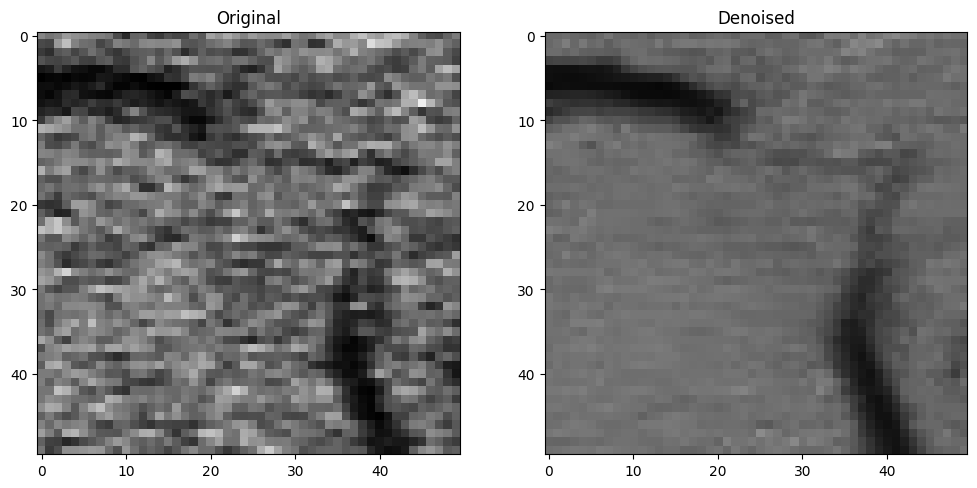

In [19]:
show_original_with_denoised(cropped_img, denoised_cropped_img)

In [17]:
denoised_img_new = denoise_nlm(img_0, search_window_size, compare_window_size, strength, sd)

1/50 rows done, elapsed time: 0.3085012435913086s
2/50 rows done, elapsed time: 0.4245905876159668s
3/50 rows done, elapsed time: 0.5531940460205078s
4/50 rows done, elapsed time: 0.6900358200073242s
5/50 rows done, elapsed time: 0.8362479209899902s
6/50 rows done, elapsed time: 0.9909019470214844s
7/50 rows done, elapsed time: 1.16127347946167s
8/50 rows done, elapsed time: 1.3341538906097412s
9/50 rows done, elapsed time: 1.5215680599212646s
10/50 rows done, elapsed time: 1.7294025421142578s
11/50 rows done, elapsed time: 2.019249677658081s
12/50 rows done, elapsed time: 2.2409796714782715s
13/50 rows done, elapsed time: 2.4557178020477295s
14/50 rows done, elapsed time: 2.6842525005340576s
15/50 rows done, elapsed time: 2.9153854846954346s
16/50 rows done, elapsed time: 3.151590585708618s
17/50 rows done, elapsed time: 3.3805418014526367s
18/50 rows done, elapsed time: 3.608982563018799s
19/50 rows done, elapsed time: 3.8393616676330566s
20/50 rows done, elapsed time: 4.068099737167

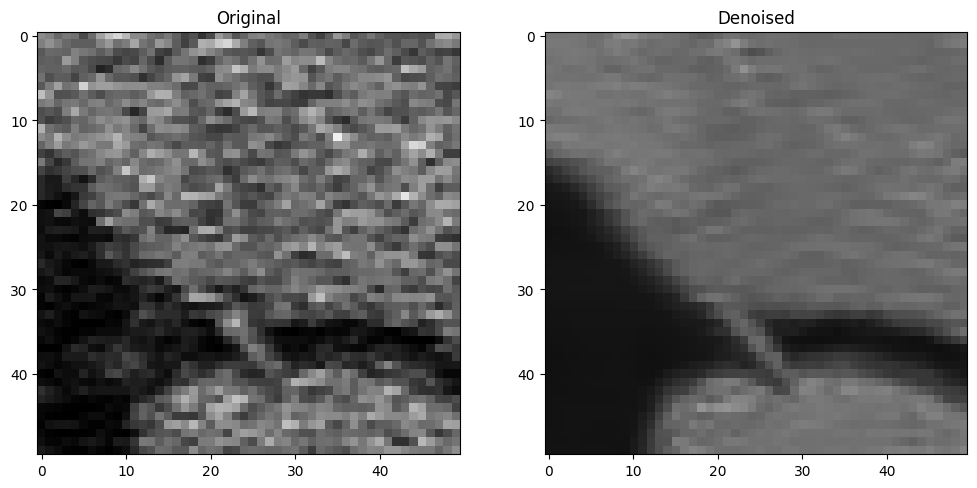

In [18]:
show_original_with_denoised(img_0, denoised_img_new)

# Different approach to history  
Instead of just performing separate NLM filter for each image in history and then averaging the result,  
now we perform 

In [9]:
# PARAMETERS
sd = 0.1254076 # estimated using R
strength = 0.35 * sd # 0.078 
compare_window_size = 7 # ODD
search_window_size = 35 # ODD! bigger than compare win

In [ ]:
# load history
i = 0
cropped_original_img = crop((imread(samples_dark_path + f"{i}.png", as_gray=True).astype(np.float64)) / 255)

count = 5
history = []
for c in range(1, 1 + count):
    history.append(crop((imread(samples_dark_path + f"{c}.png", as_gray=True).astype(np.float64)) / 255))
        
denoised_img_smart = denoise_nlm_with_history_smart(cropped_original_img, history, search_window_size, compare_window_size, strength, sd)

1/50 rows done, elapsed time: 1.0433309078216553s
2/50 rows done, elapsed time: 1.966433048248291s
3/50 rows done, elapsed time: 2.9187395572662354s
4/50 rows done, elapsed time: 3.9215707778930664s
5/50 rows done, elapsed time: 4.981387376785278s
6/50 rows done, elapsed time: 6.081648826599121s
7/50 rows done, elapsed time: 7.262962579727173s
8/50 rows done, elapsed time: 8.4829683303833s
9/50 rows done, elapsed time: 9.760966777801514s
10/50 rows done, elapsed time: 11.10114336013794s
11/50 rows done, elapsed time: 12.498836755752563s
12/50 rows done, elapsed time: 13.948137998580933s
13/50 rows done, elapsed time: 15.448599338531494s
14/50 rows done, elapsed time: 17.00218629837036s
15/50 rows done, elapsed time: 18.606489181518555s
16/50 rows done, elapsed time: 20.26158905029297s
17/50 rows done, elapsed time: 21.980300664901733s
18/50 rows done, elapsed time: 23.773894786834717s
19/50 rows done, elapsed time: 25.537681341171265s
20/50 rows done, elapsed time: 27.305376529693604s


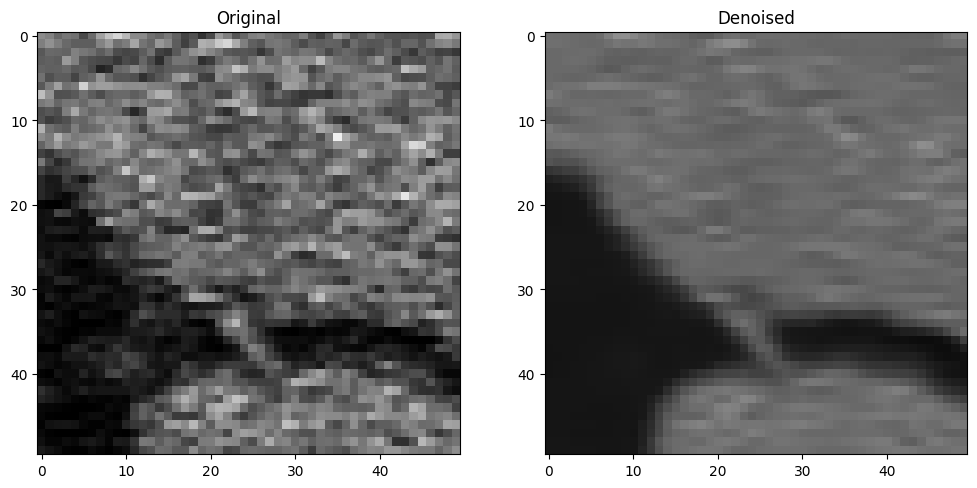

In [9]:
show_original_with_denoised(cropped_original_img, denoised_img_smart)

In [44]:
compare_img_quality(cropped_original_img, crop(img_gt_float), denoised_img_smart)

# PSNR
  66.46068772206652
  71.67332377289428
# SSIM
  0.28493636298612834
  0.3735672173645834
# MSE
  0.01468965474817378
  0.004423316175888105


# GPU optimizations

In [21]:
# PARAMETERS
sd = 0.1254076 # estimated using R
strength = 0.35 * sd # 0.078 
compare_window_size = 7 # ODD
search_window_size = 35 # ODD! bigger than compare win

compare_window_offset = int((compare_window_size - 1) // 2)
img_width = 50
img_heigth = 50
img_width_padded = img_width + 2 * compare_window_offset
img_heigth_padded = img_heigth + 2 * compare_window_offset

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [29]:
i = 0
cropped_original_img = crop((imread(samples_dark_path + f"{i}.png", as_gray=True).astype(np.float64)) / 255)
tensor_original_img = torch.from_numpy(create_padded_img(cropped_original_img, compare_window_offset))
tensor_original_img = tensor_original_img.to(device)

# load history
count = 5
history = torch.empty((count, img_heigth_padded, img_width_padded))
for c in range(1, 1 + count):
    history[c - 1] = torch.from_numpy(create_padded_img(crop((imread(samples_dark_path + f"{c}.png", as_gray=True).astype(np.float64)) / 255), compare_window_offset))
    history[c - 1] = history[c - 1].to(device)
        
gpu_denoised_img_smart = gpu_denoise_nlm_with_history_smart(tensor_original_img, history, search_window_size, compare_window_size, strength, sd)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/martinb/miniconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_12750/82585675.py", line 13, in <module>
    gpu_denoised_img_smart = gpu_denoise_nlm_with_history_smart(tensor_original_img, history, search_window_size, compare_window_size, strength, sd)
  File "/home/martinb/SCHOOL/pv162_project/nlm.py", line 252, in gpu_denoise_nlm_with_history_smart
    calculate_pixel_denoised_value_between_images(img, history_images[img_i], img_width, img_height,
  File "/home/martinb/SCHOOL/pv162_project/nlm.py", line 138, in calculate_pixel_denoised_value_between_images
    d2 = calculate_distance_squared_between_images(padded_img1, x, y, padded_img2,
  File "/home/martinb/SCHOOL/pv162_project/nlm.py", line 28, in calculate_distance_squared_between_images
    tensor_sum += torch.square(image1[y1 + f, x1 + f] - image2[y2 + f, x2 + f

# Reducing Search Window size
- This process may introduce spilling of colors, as shown above. 
- To find where is the "border" between number of history images and search window size is very problematic


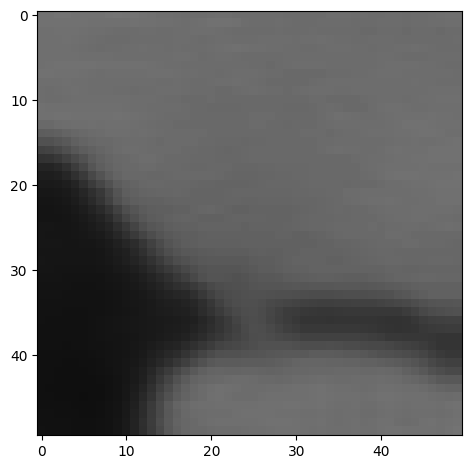

In [11]:
strength = 40
compare_window_size = 9
search_window_size = 27

cv_denoised_img = cv.fastNlMeansDenoising((img_0 * 255).astype(np.uint8), None, strength, compare_window_size, search_window_size)
imshow(cv_denoised_img)

In [13]:
# strength = 20
# noise_sd = 10
# compare_window_size = 31
# search_window_size = 101
#
# search_window_offset = int((search_window_size - 1) // 2)
# compare_window_offset = int((compare_window_size - 1) // 2)
# y_search_min = max(compare_window_offset,15 - search_window_offset)
# print(y_search_min)
#
# cv_denoised_img = cv.fastNlMeansDenoising(img, None, strength, compare_window_size, search_window_size)
# my_denoised_img = denoise_nlm(img, search_window_size, compare_window_size, strength, noise_sd)
#
#
# plt.figure(figsize=(12,6))
# plt.subplot(121).title.set_text('OpenCV NLM'), plt.imshow(cv_denoised_img, cmap='gray', vmin=0, vmax=255)
# plt.subplot(122).title.set_text('My NLM'), plt.imshow(my_denoised_img, cmap='gray', vmin=0, vmax=255)
# plt.show()

In [5]:
from PIL import Image
import numpy
import array
import sys
import random

arg_img_in = f"/home/martinb/SCHOOL/pv162_project/data/input_images/sample_1024.png"
input_img = Image.open(arg_img_in).convert('L')
(input_img_w, input_img_h) = input_img.size
left = input_img_w // 4
top = input_img_h // 4
right = input_img_w - left
bottom = input_img_h - top

rand_shift_w = random.randint(-50, 50)
rand_shift_h = random.randint(-50, 50)

img_in = input_img.crop((left + rand_shift_w, top + rand_shift_h, right + rand_shift_w, bottom + rand_shift_h))
(img_w, img_h) = img_in.size

img_in.show()

kf.service.services: KApplicationTrader: mimeType "x-scheme-handler/file" not found
kf.service.services: KApplicationTrader: mimeType "x-scheme-handler/file" not found
org.kde.kdegraphics.gwenview.lib: Unresolved mime type  "image/x-mng"
org.kde.kdegraphics.gwenview.lib: Unresolved raw mime type  "image/x-nikon-nrw"
org.kde.kdegraphics.gwenview.lib: Unresolved raw mime type  "image/x-samsung-srw"
